# Sberbank Competition (With some leakages)

In [326]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn import model_selection, preprocessing
import xgboost as xgb
import datetime

In [327]:
# Load files
train = pd.read_csv("./Data/train.csv", parse_dates=['timestamp'])
test = pd.read_csv("./Data/test.csv", parse_dates=['timestamp'])
macro = pd.read_csv("./Data/macro.csv", parse_dates=['timestamp'])
id_test = test.id

In [328]:
price_doc_1m = train[train['price_doc'] == 1000000].index
price_doc_2m = train[train['price_doc'] == 2000000].index
np.random.seed(seed=2017)
instead_1m = np.random.normal(1000000, 1000000, len(price_doc_1m))
np.random.seed(seed=2017)
instead_2m = np.random.normal(2000000, 2000000, len(price_doc_2m))

train['price_doc'][price_doc_1m] = instead_1m
train['price_doc'][price_doc_2m] = instead_2m

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel/__main__.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


## Data Cleaning

In [329]:
# Data cleaning
bad_index = train[train.life_sq > train.full_sq].index
train.ix[bad_index, "life_sq"] = np.NaN

In [330]:
equal_index = [601, 1896, 2791]
test.ix[equal_index, "life_sq"] = test.ix[equal_index, "full_sq"]

In [331]:
bad_index = test[test.life_sq > test.full_sq].index
test.ix[bad_index, "life_sq"] = np.NaN

In [332]:
bad_index = train[train.life_sq < 5].index
train.ix[bad_index, "life_sq"] = np.NaN
bad_index = test[test.life_sq < 5].index
test.ix[bad_index, "life_sq"] = np.NaN

In [333]:
bad_index = train[train.full_sq < 5].index
train.ix[bad_index, "full_sq"] = np.NaN
bad_index = test[test.full_sq < 5].index
test.ix[bad_index, "full_sq"] = np.NaN

In [334]:
kitch_is_build_year = [13117]
train.ix[kitch_is_build_year, "build_year"] = train.ix[kitch_is_build_year, "kitch_sq"]

In [335]:
bad_index = train[train.kitch_sq >= train.life_sq].index
train.ix[bad_index, "kitch_sq"] = np.NaN
bad_index = test[test.kitch_sq >= test.life_sq].index
test.ix[bad_index, "kitch_sq"] = np.NaN

In [336]:
bad_index = train[(train.kitch_sq == 0).values + (train.kitch_sq == 1).values].index
train.ix[bad_index, "kitch_sq"] = np.NaN
bad_index = test[(test.kitch_sq == 0).values + (test.kitch_sq == 1).values].index
test.ix[bad_index, "kitch_sq"] = np.NaN

In [337]:
bad_index = train[(train.full_sq > 210) & (train.life_sq / train.full_sq < 0.3)].index
train.ix[bad_index, "full_sq"] = np.NaN
bad_index = test[(test.full_sq > 150) & (test.life_sq / test.full_sq < 0.3)].index
test.ix[bad_index, "full_sq"] = np.NaN

In [338]:
bad_index = train[train.life_sq > 300].index
train.ix[bad_index, ["life_sq", "full_sq"]] = np.NaN
bad_index = test[test.life_sq > 200].index
test.ix[bad_index, ["life_sq", "full_sq"]] = np.NaN

In [339]:
bad_index = train[train.build_year < 1500].index
train.ix[bad_index, "build_year"] = np.NaN
bad_index = test[test.build_year < 1500].index
test.ix[bad_index, "build_year"] = np.NaN

In [340]:
bad_index = train[train.num_room == 0].index 
train.ix[bad_index, "num_room"] = np.NaN
bad_index = test[test.num_room == 0].index 
test.ix[bad_index, "num_room"] = np.NaN

In [341]:
bad_index = train[train.build_year > 2020].index 
train.ix[bad_index, "build_year"] = np.NaN
bad_index = test[test.build_year > 2020].index 
test.ix[bad_index, "build_year"] = np.NaN

In [342]:
bad_index = [10076, 11621, 17764, 19390, 24007, 26713, 29172]
train.ix[bad_index, "num_room"] = np.NaN
bad_index = [3174, 7313]
test.ix[bad_index, "num_room"] = np.NaN

In [343]:
bad_index = train[(train.floor == 0).values * (train.max_floor == 0).values].index
train.ix[bad_index, ["max_floor", "floor"]] = np.NaN

In [344]:
bad_index = train[train.floor == 0].index
train.ix[bad_index, "floor"] = np.NaN
bad_index = train[train.max_floor == 0].index
train.ix[bad_index, "max_floor"] = np.NaN
bad_index = test[test.max_floor == 0].index
test.ix[bad_index, "max_floor"] = np.NaN

In [345]:
bad_index = train[train.floor > train.max_floor].index
train.ix[bad_index, "max_floor"] = np.NaN
bad_index = test[test.floor > test.max_floor].index
test.ix[bad_index, "max_floor"] = np.NaN

In [346]:
bad_index = [23584]
train.ix[bad_index, "floor"] = np.NaN

In [347]:
bad_index = train[train.state == 33].index
train.ix[bad_index, "state"] = np.NaN

In [348]:
train.loc[train.full_sq == 0, 'full_sq'] = 50
train = train[train.price_doc/train.full_sq <= 600000]
train = train[train.price_doc/train.full_sq >= 10000]

## Feature Engineering

In [349]:
# Add month-year
#month_year = (train.timestamp.dt.month + train.timestamp.dt.year * 100)
#month_year_cnt_map = month_year.value_counts().to_dict()
#train['month_year_cnt'] = month_year.map(month_year_cnt_map)

#month_year = (test.timestamp.dt.month + test.timestamp.dt.year * 100)
#month_year_cnt_map = month_year.value_counts().to_dict()
#test['month_year_cnt'] = month_year.map(month_year_cnt_map)

In [350]:
# Add week-year count
#week_year = (train.timestamp.dt.weekofyear + train.timestamp.dt.year * 100)
#week_year_cnt_map = week_year.value_counts().to_dict()
#train['week_year_cnt'] = week_year.map(week_year_cnt_map)

#week_year = (test.timestamp.dt.weekofyear + test.timestamp.dt.year * 100)
#week_year_cnt_map = week_year.value_counts().to_dict()
#test['week_year_cnt'] = week_year.map(week_year_cnt_map)

In [351]:
# Add month and day-of-week
train['month'] = train.timestamp.dt.month
train['dow'] = train.timestamp.dt.dayofweek

test['month'] = test.timestamp.dt.month
test['dow'] = test.timestamp.dt.dayofweek

In [352]:
# Other feature engineering
train['rel_floor'] = train['floor'] / train['max_floor'].astype(float)
train['rel_kitch_sq'] = train['kitch_sq'] / train['full_sq'].astype(float)

test['rel_floor'] = test['floor'] / test['max_floor'].astype(float)
test['rel_kitch_sq'] = test['kitch_sq'] / test['full_sq'].astype(float)

In [353]:
train.apartment_name=train.sub_area + train['metro_km_avto'].astype(str)
test.apartment_name=test.sub_area + train['metro_km_avto'].astype(str)

In [354]:
train['room_size'] = train['life_sq'] / train['num_room'].astype(float)
test['room_size'] = test['life_sq'] / test['num_room'].astype(float)

In [355]:
y_train = train["price_doc"]
x_train = train.drop(["id", "timestamp", "price_doc"], axis=1)
x_test = test.drop(["id", "timestamp"], axis=1)

In [356]:
for c in x_train.columns:
    if x_train[c].dtype == 'object':
        lbl = preprocessing.LabelEncoder()
        lbl.fit(list(x_train[c].values)) 
        x_train[c] = lbl.transform(list(x_train[c].values))
        #x_train.drop(c,axis=1,inplace=True)
        
for c in x_test.columns:
    if x_test[c].dtype == 'object':
        lbl = preprocessing.LabelEncoder()
        lbl.fit(list(x_test[c].values)) 
        x_test[c] = lbl.transform(list(x_test[c].values))
        #x_test.drop(c,axis=1,inplace=True)  

## XGBoost

### First-level Model

In [357]:
xgb_params = {
    'eta': 0.05,
    'max_depth': 5,
    'subsample': 0.7,
    'colsample_bytree': 0.7,
    'objective': 'reg:linear',
    'eval_metric': 'rmse',
    'silent': 1
}

In [358]:
dtrain = xgb.DMatrix(x_train, y_train)
dtest = xgb.DMatrix(x_test)

[0]	train-rmse:8.26305e+06	test-rmse:8.26833e+06
[25]	train-rmse:3.37672e+06	test-rmse:3.58835e+06
[50]	train-rmse:2.33481e+06	test-rmse:2.73712e+06
[75]	train-rmse:2.09898e+06	test-rmse:2.59048e+06
[100]	train-rmse:1.9988e+06	test-rmse:2.54356e+06
[125]	train-rmse:1.93487e+06	test-rmse:2.51896e+06
[150]	train-rmse:1.88674e+06	test-rmse:2.50235e+06
[175]	train-rmse:1.84177e+06	test-rmse:2.48848e+06
[200]	train-rmse:1.80395e+06	test-rmse:2.47755e+06
[225]	train-rmse:1.76651e+06	test-rmse:2.46979e+06
[250]	train-rmse:1.73312e+06	test-rmse:2.46248e+06
[275]	train-rmse:1.70515e+06	test-rmse:2.45894e+06
[300]	train-rmse:1.67748e+06	test-rmse:2.4554e+06
[325]	train-rmse:1.65082e+06	test-rmse:2.45229e+06
[350]	train-rmse:1.62268e+06	test-rmse:2.44885e+06
[375]	train-rmse:1.59918e+06	test-rmse:2.44589e+06
[400]	train-rmse:1.57564e+06	test-rmse:2.44407e+06
[425]	train-rmse:1.55419e+06	test-rmse:2.44178e+06
[450]	train-rmse:1.53259e+06	test-rmse:2.43992e+06
[475]	train-rmse:1.51263e+06	test-rmse

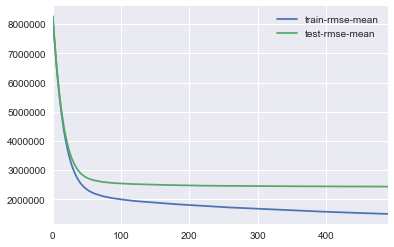

In [359]:
cv_output = xgb.cv(xgb_params, dtrain, num_boost_round=1000,
                   early_stopping_rounds=20,
                   verbose_eval=25,show_stdv=False)
cv_output[['train-rmse-mean', 'test-rmse-mean']].plot()

In [360]:
num_boost_rounds = len(cv_output)
model = xgb.train(dict(xgb_params, silent=0),
                  dtrain, num_boost_round=num_boost_rounds)

In [361]:
y_predict = model.predict(dtest)
y_predict = np.round(y_predict * 0.95)
gunja_output = pd.DataFrame({'id': id_test, 'price_doc': y_predict})
gunja_output.to_csv('sub.csv', index = False)
gunja_output.head()

,id,price_doc
0,30474,5452238.0
1,30475,7687857.0
2,30476,5493916.0
3,30477,5794967.0
4,30478,4850048.0


In [362]:
## Random Forest
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import Imputer

imp = Imputer(missing_values='NaN', strategy='median', axis=0)
imp_train = imp.fit_transform(x_train)

rf_reg = RandomForestRegressor(criterion='mse', max_depth=5,
                               max_features='auto', random_state = 2017,
                               n_estimators=500, n_jobs=-1, verbose=1)
rf_reg.fit(imp_train, y_train)

[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   16.3s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:  3.1min finished


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=5,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=500, n_jobs=-1, oob_score=False, random_state=2017,
           verbose=1, warm_start=False)

In [363]:
imp = Imputer(missing_values='NaN', strategy='median', axis=0)

imp_test = imp.fit_transform(x_test)
rf_predict = rf_reg.predict(imp_test)
gunja_output['rf_price_doc'] = np.round(rf_predict)
gunja_output.head()

[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:    0.1s finished


,id,price_doc,rf_price_doc
0,30474,5452238.0,5738744.0
1,30475,7687857.0,8442960.0
2,30476,5493916.0,5863142.0
3,30477,5794967.0,5585225.0
4,30478,4850048.0,5710103.0


In [372]:
final = pd.DataFrame({'id': id_test, 'price_doc': np.round((0.8 * y_predict + 0.2 * rf_predict))})
final.to_csv('sub_final.csv', index = False)
final.head()

,id,price_doc
0,30474,5523864.0
1,30475,7876633.0
2,30476,5586223.0
3,30477,5742531.0
4,30478,5065062.0
